In [1]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import PIL
import glob
from datetime import datetime

In [21]:
df = pd.read_csv('data/votos_senado.csv')

In [27]:
df.head()

,candidato_id,candidato_name,candidato_part,candidato_uf,date,proposition_id,proposition_name,sessao_desc,sessao_id,voto,ano
0,1023,Maria do Carmo do Nascimento Alves,DEM,SE,2012-04-25,103817,OFS 61/2011,21259,67,0,2012
1,70,José Renan Vasconcelos Calheiros,MDB,AL,2012-04-25,103817,OFS 61/2011,21259,67,0,2012
2,72,Roberto Requião de Mello e Silva,MDB,PR,2012-04-25,103817,OFS 61/2011,21259,67,0,2012
3,73,Romero Jucá Filho,MDB,RR,2012-04-25,103817,OFS 61/2011,21259,67,0,2012
4,40,José Agripino Maia,DEM,RN,2012-04-25,103817,OFS 61/2011,21259,67,0,2012


In [22]:
df.groupby(['proposition_name'])['sessao_desc'].apply(lambda x: x.unique().shape[0]).value_counts()

1    784
2     45
3      2
Name: sessao_desc, dtype: int64

In [23]:
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['ano'] = df['date'].apply(lambda x:x.year)

In [24]:
df.columns

Index(['candidato_id', 'candidato_name', 'candidato_part', 'candidato_uf',
       'date', 'proposition_id', 'proposition_name', 'sessao_desc',
       'sessao_id', 'voto', 'ano'],
      dtype='object')

In [37]:
df['candidato_part'].fillna('S/Partido', inplace=True)
df['candidato_uf'].fillna('', inplace=True)

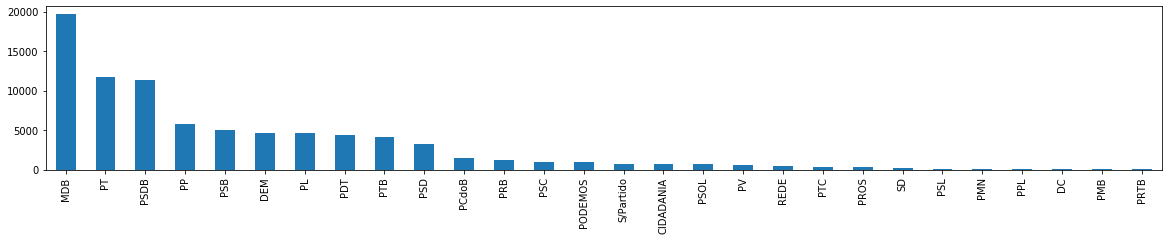

In [25]:
plt.figure(figsize=(20,3))
df['candidato_part'].value_counts().plot(kind="bar")

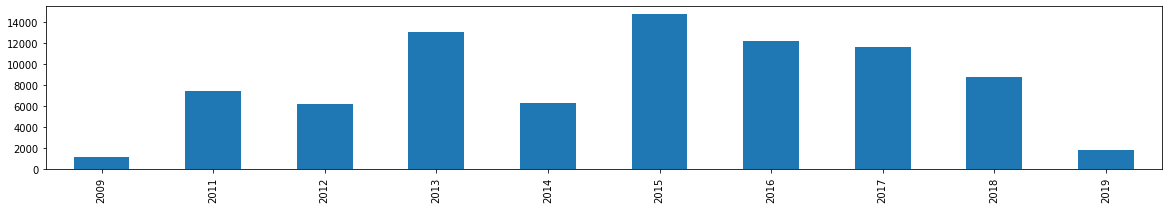

In [38]:
plt.figure(figsize=(20,3))
df['ano'].value_counts().sort_index().plot(kind="bar")

In [56]:
v = pd.pivot_table(df, values='voto', index=['candidato_id', 'candidato_part'], columns='proposition_id', fill_value=0)

In [57]:
v.head()

,proposition_id,56281,60148,72589,80152,80384,80674,82419,83009,83840,84005,...,135079,135087,135088,135250,135251,135252,135603,135983,136173,136357
candidato_id,candidato_part,,,,,,,,,,,,,,,,,,,,,
3,PSB,1.0,0,1,1,1,1.0,1.0,1,1,1,...,0,0,0,0,0,0,0,0.0,0,0
13,MDB,1.0,1,0,0,0,0.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0
16,MDB,0.0,0,0,0,0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0
17,PT,1.0,1,0,0,1,1.0,1.0,1,1,1,...,0,0,0,0,0,0,0,0.0,0,0
20,PTB,1.0,0,1,0,1,1.0,1.0,1,1,1,...,0,0,0,0,0,0,0,0.0,0,0


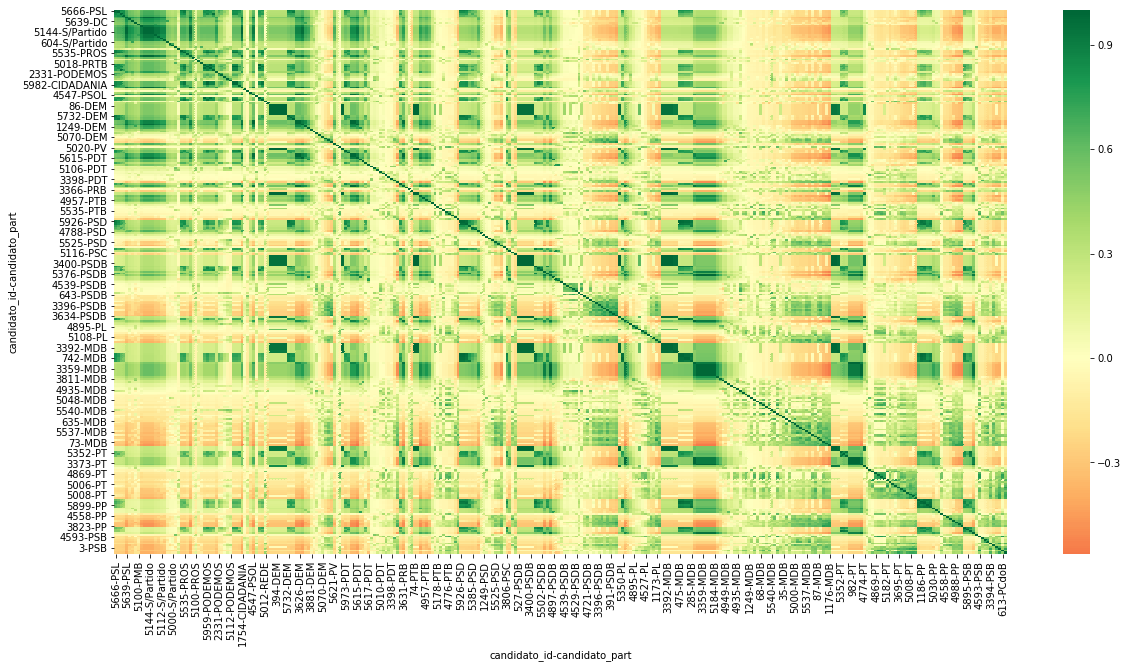

In [59]:
v['x'] = PCA(1).fit_transform(v)
x_part = v.groupby('candidato_part')['x'].mean()
v = v.merge(x_part, how='inner', left_on='candidato_part', right_index=True, suffixes=['', '_part'])
plt.figure(figsize=(20,10))
v = v.sort_values(['x_part', 'x'])
sns.heatmap(v.T.corr(), cmap='RdYlGn', center=0)
v.drop(['x_part', 'x'], axis=1, inplace=True)
plt.show()

In [60]:
part = v.reset_index().drop('candidato_id', axis=1).groupby('candidato_part').mean()

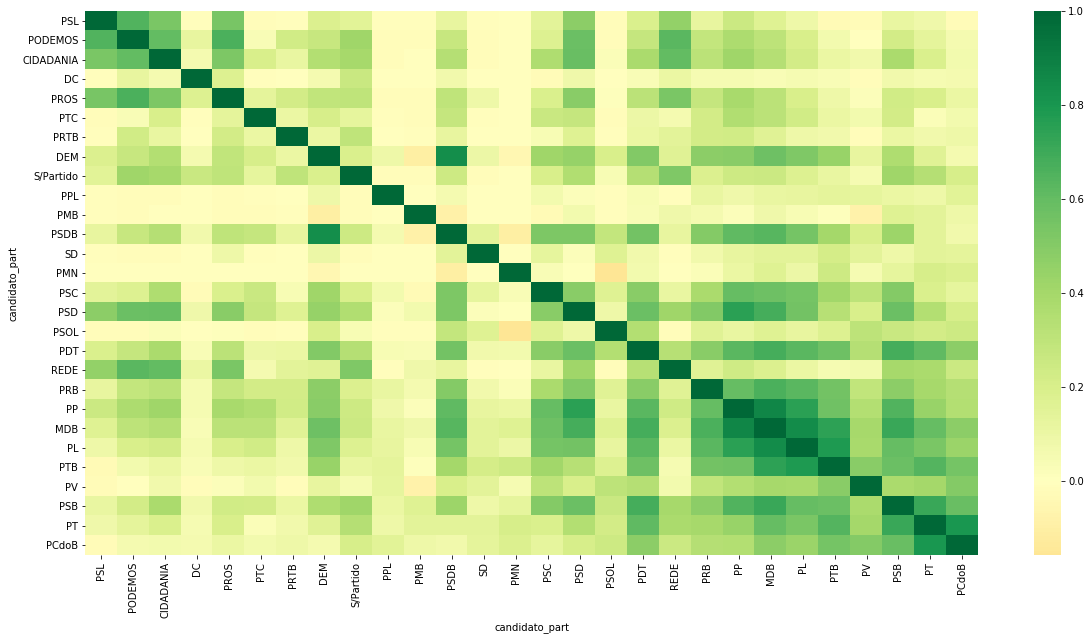

In [63]:
part['x'] = PCA(1).fit_transform(part)
part = part.sort_values('x')
part.drop('x', axis=1, inplace=True)

plt.figure(figsize=(20,10))
sns.heatmap(part.T.corr(), cmap='RdYlGn', center=0)
plt.show()

IndexError: list index out of range

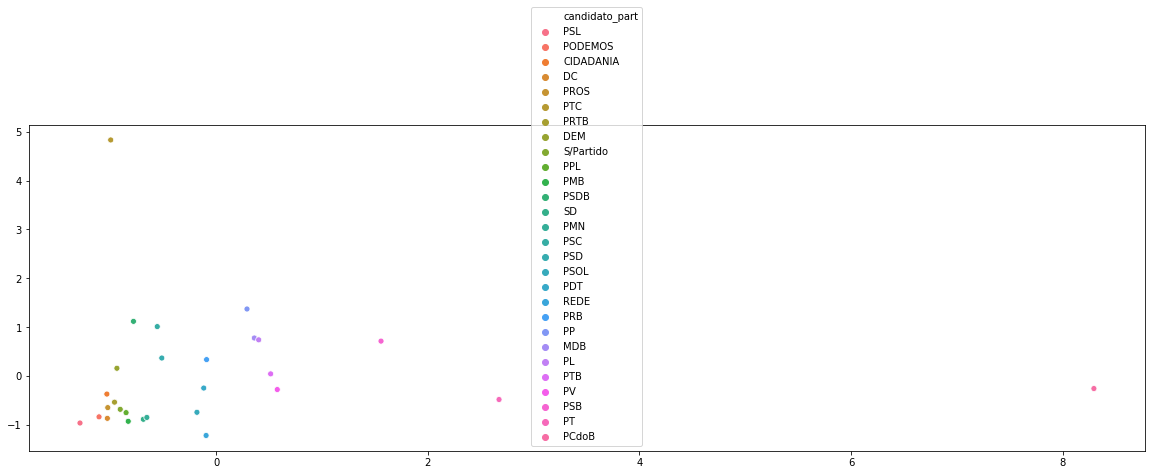

In [64]:
x, y = PCA(2).fit_transform(part).T
fig, ax = plt.subplots(figsize=(20, 6))

def getImage(partido):
    p = partido.upper().replace(' ', '')
    path = glob.glob(f"../logos/{p}.*")[0]
    img = PIL.Image.open(path)
    img.thumbnail((50, 50))
    return OffsetImage(img)

sns.scatterplot(x, y, hue=part.index)
for x0, y0, path in zip(x, y, part.index.tolist()):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

In [81]:
x, y = PCA(2).fit_transform(v).T

plt.figure(figsize=(20,10))
partido = v.index.get_level_values('partido')
sns.scatterplot(x, y, hue=partido)